In [1]:
!nvidia-smi

Sat Aug  8 13:22:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import torch 
import torch.nn as nn
import torchvision
import numpy as np 
import pandas as pd
import random
import os
import glob
import copy
import cv2
from tqdm import tqdm as tqdm
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
from PIL import Image

# for creating validation set
from sklearn.model_selection import train_test_split

seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)


best_model = None
best_loss = 0.
best_test_loss = 0.
best_test_acc = 0.
best_pred_labels = []
true_labels = []

pred_labels = []
test_acc = 0.
test_loss = 0.

# device = torch.device('cuda:0')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Copied files from drive to local, for faster training/processing

!cp -R /content/drive/"My Drive"/APTOS/Dataset/train_images ./


In [5]:
!cp -R /content/drive/"My Drive"/APTOS/Dataset/train.csv ./

In [6]:
!ls -lrt

total 196
drwxr-xr-x 1 root root   4096 Jul 30 16:30 sample_data
drwx------ 4 root root   4096 Aug  8 13:23 drive
drwx------ 2 root root 131072 Aug  8 14:00 train_images
-rw------- 1 root root  54948 Aug  8 14:00 train.csv


In [7]:
# Train samples from Non DP data
print('All Samples in Train Data')
!ls -l train_images | wc -l

All Samples in Train Data
3663


In [8]:
# Create APTOS Dataset class

class APTOSData(Dataset):
    def __init__(self, data_dir, df_data, transform = None):
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name, label = self.df[idx]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path) 
        if self.transform is not None:
            image = self.transform(image)     
        return image, label

In [9]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),                                          
    torchvision.transforms.Resize(256),
    torchvision.transforms.RandomAffine(0, translate=(0, 0.1), scale=(1, 1.10)),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),                                         
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])



In [10]:
df = pd.read_csv('train.csv')

print("Number of Labels :{}".format(len(np.unique(df['diagnosis']))))

Number of Labels :5


In [11]:
train_dataset = APTOSData('train_images', df , transform=train_transforms)

In [12]:
train_idx, valid_idx= train_test_split(
    np.arange(len(train_dataset)), test_size=0.21, random_state=42, shuffle=True, stratify=df['diagnosis'])

In [13]:
print(len(valid_idx))
print(len(train_idx))

770
2892


In [14]:
# Create Samplers
# Pass train_sampler to train_data , this gives non images for training
# Pass valid_sampler to train_dataset, this gives non dp images for validation
# We are not using DP images here
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, sampler = train_sampler)
val_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, sampler = valid_sampler)

### Original Images

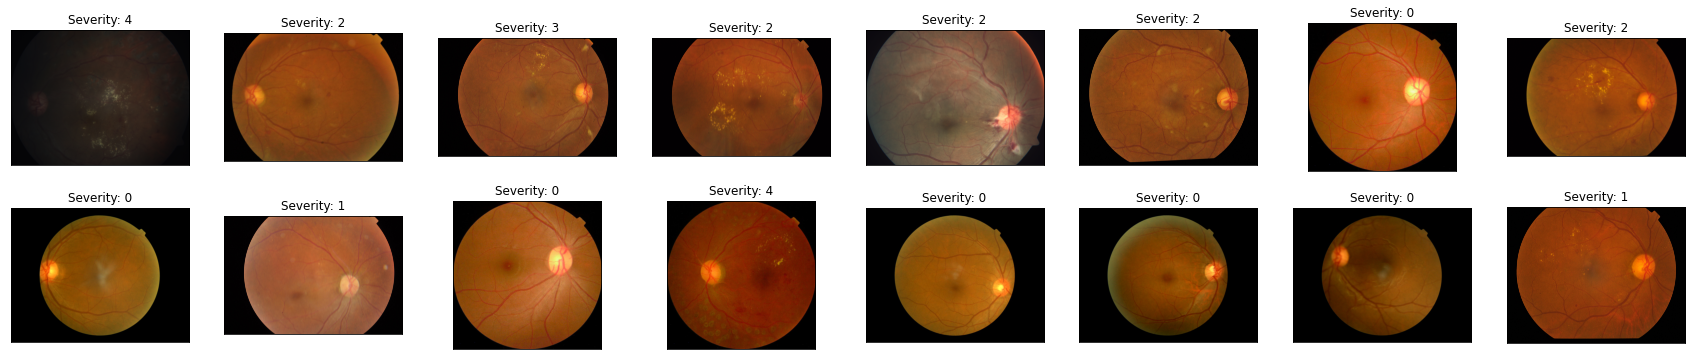

In [15]:
fig = plt.figure(figsize=(30, 6))
#base_dir = '/content/drive/My Drive/APTOS/Dataset'
base_dir = './'
# display 20 images
train_imgs = os.listdir(base_dir+"/train_images")
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open(base_dir+"/train_images/" + img)
    plt.imshow(im)
    lab = df.loc[df['id_code'] == img.split('.')[0], 'diagnosis'].values[0]
    ax.set_title('Severity: %s'%lab)

In [16]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(in_features=512, out_features=5)
model = model.to(device)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
summary(model.cuda(), [(3,224,224,)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [18]:
def deactivate_batchnorm(m):
    if isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()
        m.eval()
        #m.affine = False
        #m.track_running_stats = False
        with torch.no_grad():
            m.weight.fill_(1.0)
            m.bias.zero_()

In [19]:
def clip_grad(parameters, max_norm, norm_type=2):
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type

In [20]:
def train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train'):
    """
    Differentially Private version of the training procedure
    :param trainloader:
    :param model:
    :param optimizer:
    :param epoch:
    :return:
    """
    model.train()
    model.apply(deactivate_batchnorm)
    running_loss = 0.0
    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []
    num_microbatches = 2
    S = 0.3
    z = 12.95 # DP-SGD with sampling rate = 4.37% and noise_multiplier = 12.95 iterated over 1145 steps satisfies differential privacy with eps = 0.5 and delta = 0.0001.
            # The optimal RDP order is 38.0.
    sigma = z * S
    for batch_idx, data in tqdm(enumerate(trainloader, 0), leave=True):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        #print(loss.shape)
        running_loss += torch.mean(loss).item()

        true_labels.append(labels.detach().cpu())
        pred_labels.append(preds.detach().cpu())

        losses = torch.mean(loss.reshape(num_microbatches, -1), dim=1)
        saved_var = dict()
        for tensor_name, tensor in model.named_parameters():
            saved_var[tensor_name] = torch.zeros_like(tensor)

        for j in losses:
            j.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), S)
            for tensor_name, tensor in model.named_parameters():
                new_grad = tensor.grad
                saved_var[tensor_name].add_(new_grad)
            model.zero_grad()

        for tensor_name, tensor in model.named_parameters():
            if device.type =='cuda':
                noise = torch.cuda.FloatTensor(tensor.grad.shape).normal_(0, sigma)
                #noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            else:
                noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            saved_var[tensor_name].add_(noise)
            tensor.grad = saved_var[tensor_name] / num_microbatches
        optimizer.step()

        #print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {loss}', end='', flush=True)
        ##print(f'\r{phase} batch [{batch_idx}/{len(trainloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
        epoch_loss += torch.mean(loss.detach().cpu()).item()
        epoch_acc += torch.sum(preds == labels.data)
        batch_num += 1
        samples_num += len(labels)

        '''if i > 0 and i % 20 == 0:
            #             logger.info('[%d, %5d] loss: %.3f' %
            #                   (epoch + 1, i + 1, running_loss / 2000))
            plot(epoch * len(trainloader) + i, running_loss, 'Train Loss')
            running_loss = 0.0'''
    #print("RETURNING........")
    return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()      

In [21]:
def test(model, testloader, criterion, optimizer, lr_scheduler, phase='test'):
    model.eval()
    model.apply(deactivate_batchnorm)
    #correct = 0
    #total = 0

    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch_idx, data in  enumerate(testloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #_, predicted = torch.max(outputs.data, 1)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            true_labels.append(labels.detach().cpu())
            pred_labels.append(preds.detach().cpu())

            # print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {loss}', end='', flush=True)
            ##print(f'\r{phase} batch [{batch_idx}/{len(testloader)}]: loss {torch.mean(loss).item()}', end='', flush=True)
            epoch_loss += torch.mean(loss.detach().cpu()).item()
            epoch_acc += torch.sum(preds == labels.data)
            batch_num += 1
            samples_num += len(labels)

            #total += labels.size(0)
            #correct += (predicted == labels).sum().item()
        #print("TESTING.....")
        return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [22]:
criterion = torch.nn.CrossEntropyLoss(reduction='none')
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001)
optimizer = torch.optim.SGD([{'params': [param for name, param in model.named_parameters() if 'fc' not in name]}, {'params': model.fc.parameters(), 'lr': 1e-3}], lr=5e-4, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [23]:
train_losses = []
val_losses = []
test_losses = []

for epoch in range(50):
    print('='*15, f'Epoch: {epoch}')
    
#train_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train')
#test(model, testloader, criterion, optimizer, lr_scheduler, phase='test')

    train_loss, train_acc, _, _ = train_dp(model, train_dataloader, criterion, optimizer, lr_scheduler)
    val_loss, val_acc, _, _ = test(model, val_dataloader, criterion, optimizer, lr_scheduler, phase='val')
    #test_loss, test_acc, true_labels, pred_labels = run_epoch(model, test_dataloader, criterion, optimizer, lr_scheduler, phase='test')
    
    print()
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
    print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
    #print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')
    print()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    #test_losses.append(test_loss)
    
    torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-{seed}.pt')
    
    if best_model is None or val_loss < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        #best_test_loss = test_loss
        #best_test_acc = test_acc 
        best_pred_labels = pred_labels
        torch.save({'epoch': epoch, 'model': model.state_dict()}, f'resnet34-mooney-chest-x-ray-best-{seed}.pt')

0it [00:00, ?it/s]

=============== Epoch: 0


23it [04:34, 11.95s/it]



Train loss: 1.6637168448904287, Train accuracy: 0.10131397098302841
Val loss: 1.6710845572607858, Val accuracy: 0.10129869729280472



0it [00:00, ?it/s]

=============== Epoch: 1


23it [04:20, 11.31s/it]



Train loss: 1.6091067531834478, Train accuracy: 0.23582296073436737
Val loss: 1.5506390844072615, Val accuracy: 0.45324674248695374



0it [00:00, ?it/s]

=============== Epoch: 2


23it [04:19, 11.26s/it]
0it [00:00, ?it/s]


Train loss: 1.560356591058814, Train accuracy: 0.4446749687194824
Val loss: 1.555916156087603, Val accuracy: 0.492207795381546

=============== Epoch: 3


23it [04:17, 11.20s/it]



Train loss: 1.5329907303271086, Train accuracy: 0.4840940535068512
Val loss: 1.5486296585627966, Val accuracy: 0.44545453786849976



0it [00:00, ?it/s]

=============== Epoch: 4


23it [04:18, 11.25s/it]



Train loss: 1.5436486316763836, Train accuracy: 0.3841632306575775
Val loss: 1.5412421907697404, Val accuracy: 0.3636363446712494



0it [00:00, ?it/s]

=============== Epoch: 5


23it [04:17, 11.18s/it]



Train loss: 1.5213657669399097, Train accuracy: 0.4159751236438751
Val loss: 1.474069288798741, Val accuracy: 0.492207795381546



0it [00:00, ?it/s]

=============== Epoch: 6


23it [04:17, 11.18s/it]



Train loss: 1.4865667301675547, Train accuracy: 0.4903181195259094
Val loss: 1.464676124708993, Val accuracy: 0.48961037397384644



0it [00:00, ?it/s]

=============== Epoch: 7


23it [04:17, 11.19s/it]
0it [00:00, ?it/s]


Train loss: 1.4812214011731355, Train accuracy: 0.4913554787635803
Val loss: 1.5263462236949377, Val accuracy: 0.49090906977653503

=============== Epoch: 8


23it [04:16, 11.16s/it]
0it [00:00, ?it/s]


Train loss: 1.5221326610316401, Train accuracy: 0.476141095161438
Val loss: 1.6091882160731725, Val accuracy: 0.48311686515808105

=============== Epoch: 9


23it [04:15, 11.10s/it]



Train loss: 1.509090579074362, Train accuracy: 0.47095435857772827
Val loss: 1.4379031828471593, Val accuracy: 0.4701298475265503



0it [00:00, ?it/s]

=============== Epoch: 10


23it [04:17, 11.19s/it]
0it [00:00, ?it/s]


Train loss: 1.5489326663639233, Train accuracy: 0.4215076267719269
Val loss: 1.5273270947592599, Val accuracy: 0.41558441519737244

=============== Epoch: 11


23it [04:24, 11.48s/it]
0it [00:00, ?it/s]


Train loss: 1.5611300312954446, Train accuracy: 0.396957129240036
Val loss: 1.5337685346603394, Val accuracy: 0.3155844211578369

=============== Epoch: 12


23it [04:24, 11.51s/it]
0it [00:00, ?it/s]


Train loss: 1.5814708989599477, Train accuracy: 0.2859612703323364
Val loss: 1.7454667602266585, Val accuracy: 0.3181818127632141

=============== Epoch: 13


23it [04:21, 11.37s/it]



Train loss: 1.5422335344812144, Train accuracy: 0.4515905976295471
Val loss: 1.4230425698416573, Val accuracy: 0.492207795381546



0it [00:00, ?it/s]

=============== Epoch: 14


23it [04:21, 11.37s/it]
0it [00:00, ?it/s]


Train loss: 1.4807059298390928, Train accuracy: 0.4930843710899353
Val loss: 1.4727575949260168, Val accuracy: 0.49090906977653503

=============== Epoch: 15


23it [04:25, 11.56s/it]
0it [00:00, ?it/s]


Train loss: 1.4511325359344482, Train accuracy: 0.4930843710899353
Val loss: 1.542032275881086, Val accuracy: 0.492207795381546

=============== Epoch: 16


23it [04:23, 11.45s/it]



Train loss: 1.4115327803984932, Train accuracy: 0.4930843710899353
Val loss: 1.3082643066133772, Val accuracy: 0.492207795381546



0it [00:00, ?it/s]

=============== Epoch: 17


23it [04:23, 11.44s/it]
0it [00:00, ?it/s]


Train loss: 1.4161879860836526, Train accuracy: 0.4353388845920563
Val loss: 1.5000842298780168, Val accuracy: 0.3519480526447296

=============== Epoch: 18


23it [04:20, 11.34s/it]
0it [00:00, ?it/s]


Train loss: 1.4554612895716792, Train accuracy: 0.2679806351661682
Val loss: 1.4000339678355627, Val accuracy: 0.27402597665786743

=============== Epoch: 19


23it [04:15, 11.10s/it]
0it [00:00, ?it/s]


Train loss: 1.43083785927814, Train accuracy: 0.27939143776893616
Val loss: 1.3873947518212455, Val accuracy: 0.366233766078949

=============== Epoch: 20


23it [04:14, 11.04s/it]
0it [00:00, ?it/s]


Train loss: 1.3707465088885764, Train accuracy: 0.36687415838241577
Val loss: 1.4434317350387573, Val accuracy: 0.27272728085517883

=============== Epoch: 21


23it [04:14, 11.07s/it]
0it [00:00, ?it/s]


Train loss: 1.3922688183577165, Train accuracy: 0.28215768933296204
Val loss: 1.3863649879183089, Val accuracy: 0.26363635063171387

=============== Epoch: 22


23it [04:14, 11.04s/it]
0it [00:00, ?it/s]


Train loss: 1.400488837905552, Train accuracy: 0.2946058213710785
Val loss: 1.3422233036586217, Val accuracy: 0.26103895902633667

=============== Epoch: 23


23it [04:13, 11.04s/it]
0it [00:00, ?it/s]


Train loss: 1.3589903634527456, Train accuracy: 0.36168742179870605
Val loss: 1.3681868485042028, Val accuracy: 0.516883134841919

=============== Epoch: 24


23it [04:13, 11.02s/it]



Train loss: 1.2853870288185452, Train accuracy: 0.4782157838344574
Val loss: 1.2391905784606934, Val accuracy: 0.48961037397384644



0it [00:00, ?it/s]

=============== Epoch: 25


23it [04:13, 11.03s/it]
0it [00:00, ?it/s]


Train loss: 1.2816339420235676, Train accuracy: 0.4930843710899353
Val loss: 1.5415383236748832, Val accuracy: 0.492207795381546

=============== Epoch: 26


23it [04:14, 11.06s/it]
0it [00:00, ?it/s]


Train loss: 1.3174268992050835, Train accuracy: 0.4868603050708771
Val loss: 1.4257388625826155, Val accuracy: 0.4376623332500458

=============== Epoch: 27


23it [04:14, 11.04s/it]
0it [00:00, ?it/s]


Train loss: 1.3760977154192717, Train accuracy: 0.41044262051582336
Val loss: 1.4158680438995361, Val accuracy: 0.3272727131843567

=============== Epoch: 28


23it [04:14, 11.05s/it]
0it [00:00, ?it/s]


Train loss: 1.4051761730857517, Train accuracy: 0.3869294822216034
Val loss: 1.3539731204509735, Val accuracy: 0.2805194854736328

=============== Epoch: 29


23it [04:15, 11.12s/it]
0it [00:00, ?it/s]


Train loss: 1.4323158005009526, Train accuracy: 0.3167358338832855
Val loss: 1.3986694642475672, Val accuracy: 0.4415584206581116

=============== Epoch: 30


23it [04:19, 11.28s/it]
0it [00:00, ?it/s]


Train loss: 1.3667787676272185, Train accuracy: 0.4685339033603668
Val loss: 1.3180434363228934, Val accuracy: 0.48831167817115784

=============== Epoch: 31


23it [04:19, 11.29s/it]
0it [00:00, ?it/s]


Train loss: 1.36717644981716, Train accuracy: 0.4751037359237671
Val loss: 1.4305187634059362, Val accuracy: 0.4012987017631531

=============== Epoch: 32


23it [04:19, 11.28s/it]
0it [00:00, ?it/s]


Train loss: 1.4022655901701555, Train accuracy: 0.40145230293273926
Val loss: 1.3698650598526, Val accuracy: 0.432467520236969

=============== Epoch: 33


23it [04:18, 11.25s/it]
0it [00:00, ?it/s]


Train loss: 1.4630968104238096, Train accuracy: 0.39142462611198425
Val loss: 1.5493910482951574, Val accuracy: 0.2467532455921173

=============== Epoch: 34


23it [04:22, 11.43s/it]
0it [00:00, ?it/s]


Train loss: 1.5779066293135933, Train accuracy: 0.27247580885887146
Val loss: 1.6567042555127824, Val accuracy: 0.24155843257904053

=============== Epoch: 35


23it [04:20, 11.34s/it]
0it [00:00, ?it/s]


Train loss: 1.613356149714926, Train accuracy: 0.27040112018585205
Val loss: 1.8890242406300135, Val accuracy: 0.27012985944747925

=============== Epoch: 36


23it [04:22, 11.43s/it]
0it [00:00, ?it/s]


Train loss: 1.7708313983419668, Train accuracy: 0.2648686170578003
Val loss: 1.8321911096572876, Val accuracy: 0.23246753215789795

=============== Epoch: 37


23it [04:24, 11.51s/it]
0it [00:00, ?it/s]


Train loss: 1.6642005754553753, Train accuracy: 0.25449517369270325
Val loss: 1.3806836264474052, Val accuracy: 0.34805193543434143

=============== Epoch: 38


23it [04:23, 11.44s/it]
0it [00:00, ?it/s]


Train loss: 1.502250464066215, Train accuracy: 0.30601659417152405
Val loss: 1.5010082381112235, Val accuracy: 0.3922077715396881

=============== Epoch: 39


23it [04:22, 11.41s/it]
0it [00:00, ?it/s]


Train loss: 1.4642611482869023, Train accuracy: 0.3910788595676422
Val loss: 1.472998925617763, Val accuracy: 0.45064935088157654

=============== Epoch: 40


23it [04:24, 11.49s/it]
0it [00:00, ?it/s]


Train loss: 1.6804679839507393, Train accuracy: 0.37275242805480957
Val loss: 2.3863726343427385, Val accuracy: 0.27272728085517883

=============== Epoch: 41


23it [04:23, 11.45s/it]
0it [00:00, ?it/s]


Train loss: 2.0562328463015347, Train accuracy: 0.2710926830768585
Val loss: 1.9160371678216117, Val accuracy: 0.27012985944747925

=============== Epoch: 42


23it [04:22, 11.42s/it]
0it [00:00, ?it/s]


Train loss: 2.0745972654093867, Train accuracy: 0.16493776440620422
Val loss: 2.4484836033412387, Val accuracy: 0.13246752321720123

=============== Epoch: 43


23it [04:21, 11.39s/it]
0it [00:00, ?it/s]


Train loss: 2.0043677558069644, Train accuracy: 0.12966805696487427
Val loss: 1.8589258364268713, Val accuracy: 0.13116882741451263

=============== Epoch: 44


23it [04:19, 11.27s/it]
0it [00:00, ?it/s]


Train loss: 1.8927946038868115, Train accuracy: 0.1199861690402031
Val loss: 1.4690442425864083, Val accuracy: 0.440259724855423

=============== Epoch: 45


23it [04:19, 11.29s/it]
0it [00:00, ?it/s]


Train loss: 1.6695842691089795, Train accuracy: 0.29529738426208496
Val loss: 2.2590481553758894, Val accuracy: 0.1428571343421936

=============== Epoch: 46


23it [04:20, 11.34s/it]
0it [00:00, ?it/s]


Train loss: 1.6700983151145603, Train accuracy: 0.2430843710899353
Val loss: 1.625332270349775, Val accuracy: 0.2493506371974945

=============== Epoch: 47


23it [04:16, 11.14s/it]
0it [00:00, ?it/s]


Train loss: 1.6391349668088167, Train accuracy: 0.3125864565372467
Val loss: 1.6382368803024292, Val accuracy: 0.3272727131843567

=============== Epoch: 48


23it [04:15, 11.09s/it]
0it [00:00, ?it/s]


Train loss: 1.744737112003824, Train accuracy: 0.3392116129398346
Val loss: 1.640885659626552, Val accuracy: 0.3987012803554535

=============== Epoch: 49


23it [04:14, 11.06s/it]



Train loss: 2.0242645999659663, Train accuracy: 0.3105117678642273
Val loss: 2.286952699933733, Val accuracy: 0.17012986540794373

